# Change detection in time series

Change detection is quite a common task in time series analysis.
In the follwing we consider one of the most classical examples – detection of monsoon seasons based on weather patterns.
A monsoon is a seasonal change in the direction of winds of a region. Monsoons cause wet and dry seasons and they occur in tropical areas.
We use rainfall as an indicator from which we deduce the season. As such we must decide when the change in the rainfall is large enough to change the current label for the season. In a way, we must find a balance between reacting to the changes in rainfall levels and preserving labels for large enough stretches of time. 

There are many other similar tasks:

* detection of harvest events from satellite imagery
* detection of congestion levels based on aggregated location data
* detection of CPU loads or computation types based on heat or acustic signals
* detection of life-critical situations from medical sensors

In all of these tasks, short deviations in the outputs are not enough to declare regime changes. 

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn
import string

from pandas import Series
from pandas import DataFrame
from typing import List,Tuple

from pandas import Categorical
from pandas.api.types import CategoricalDtype

from scipy.stats import norm

from tqdm import tnrange#, tqdm_notebook
from sklearn.linear_model import LogisticRegression
from plotnine import *

# Local imports
from common import *
from convenience import *

## I. Data import and preprocessing

As the whether data comes in a bunch of csv files in latin1 encoding, we must do some preprocessing to get the data into usable format.
For simplicity, we drop a couple of indicators that could be used in a more detailed analysis. You might do a more thorough data import later.

In [2]:
# Import data
df=[None] * 12
for i in range(1,13):
    df[i-1] = pd.read_csv('data/weather-data/DAILYDATA_S24_2018{:02d}.csv'.format(i), encoding='latin1')
df = pd.concat(df, ignore_index=True)
display(head(df))

# Simplify its format
df = (df.iloc[:, [2,3,4,8,11]]
      .set_axis(['month', 'day', 'rainfall', 'temperature', 'wind_speed'], axis='columns', inplace=False)
      .assign(date = lambda df: pd.to_datetime(df['day'].map(str) +'/' + df['month'].map(str)+'/2018', format='%d/%m/%Y'))
      [['date', 'rainfall', 'temperature', 'wind_speed']])
display(head(df))

,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h)
0,Changi,2018,1,1,32.2,6.0,11.6,13.4,24.8,26.7,23.6,5.4,36.0
1,Changi,2018,1,2,0.8,0.4,0.4,0.4,25.5,27.3,24.3,7.9,24.5
2,Changi,2018,1,3,2.0,1.8,2.0,2.0,26.6,31.1,24.1,7.2,29.2
3,Changi,2018,1,4,0.2,0.2,0.2,0.2,26.1,28.2,25.0,8.3,23.8
4,Changi,2018,1,5,1.0,1.0,1.0,1.0,26.0,29.0,24.8,4.3,18.7


,date,rainfall,temperature,wind_speed
0,2018-01-01,32.2,24.8,5.4
1,2018-01-02,0.8,25.5,7.9
2,2018-01-03,2.0,26.6,7.2
3,2018-01-04,0.2,26.1,8.3
4,2018-01-05,1.0,26.0,4.3


## II. Initial visualisation of the rainfall data

The next step would be to find out how to model the data as a mixture of two normal distributions:
* the first component would model the rainfall on dry days
* the second component would model the rainfall on wet days

We do not know which sample comes from which distribution but hopefully we can see two bumps on the rainfall histogram on which we can fit normal distributions. This is not the proper way to find the parameters for hidden markov models but before having seen expectation maximisation algorithm, we do not know how to do better.   

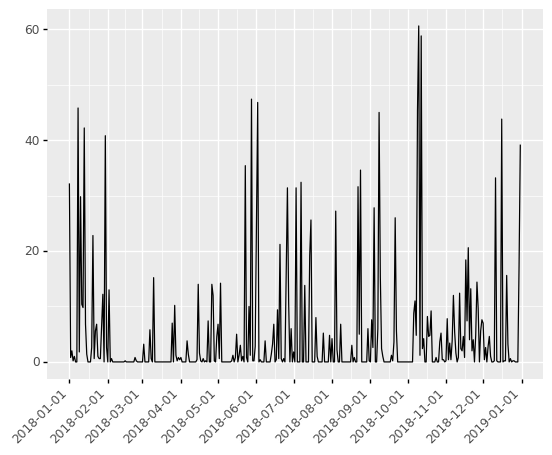

<ggplot: (343464683)>

In [3]:
p = ggplot(df)
p = p + geom_line(aes(x = 'date', y = 'rainfall'))
p = p + scale_x_date(name='', date_breaks = '1 month')
p = p + scale_y_continuous(name='')
p = p + theme(axis_text_x=element_text(rotation=45, hjust=1))
p.save('rainfall_data.pdf', path='results', height=6, width=12, verbose=False)
display(p)

### Analysis of histograms

Let's look at the histogram to see if the rainfall measurements can be split into several groups.

In [4]:
df = (df
      .assign(quartile = lambda df: 
        3 - (df['rainfall']<=df['rainfall'].quantile(q = 0.25)) 
          - (df['rainfall']<=df['rainfall'].quantile(q = 0.50))
          - (df['rainfall']<=df['rainfall'].quantile(q = 0.75)))
      .assign(quartile = lambda df: Series(['I quantile', 'II quantile', 'III quantile', 'IV quantile'])[df['quartile']].tolist()))

/Users/swen/Library/miniforge3/envs/machine-learning/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


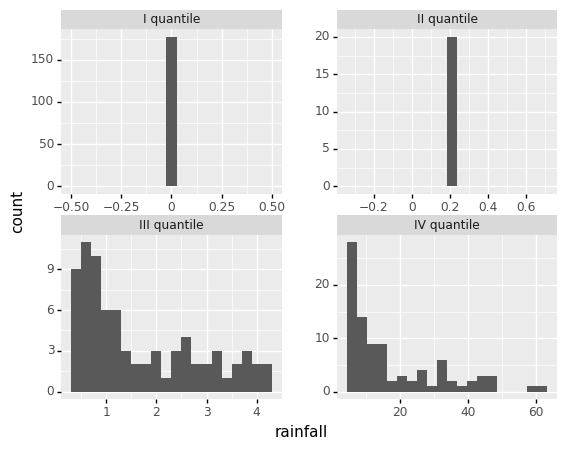

<ggplot: (343629264)>

In [5]:
p = ggplot(df) 
p = p + geom_histogram(aes(x = 'rainfall'), bins=20)
p = p + theme(subplots_adjust={'wspace': 0.25, 'hspace': 0.25})
p + facet_wrap(['quartile'], 2, 2, scales="free") + theme(panel_spacing = 0.25) 

The picture clearly shows that on $50%$ days there are almost no rain at all and all the interesting action occurs in the third and fourth quartile. However, even in these regions the rainfall does not follow the normal distribution. The histogram is left-skewed. Let us still do our best to split this distribution into two sub-distributions that could be approximated with normal distributions. It seems possible to split the data somewhat naturally between 2 and 4.

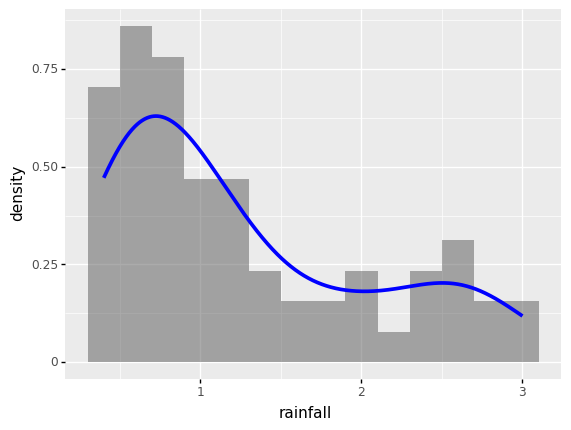

<ggplot: (381691067)>

In [6]:
p = ggplot(df.loc[(df['rainfall'] >= 0.4) & (df['rainfall']<=3)] )
p = p + geom_histogram(aes(x = 'rainfall', y='..density..'), binwidth=0.2, alpha=0.5)
p + stat_density(aes(x = 'rainfall'), geom = "line", position = "identity", color = 'blue', size = 1.5)  

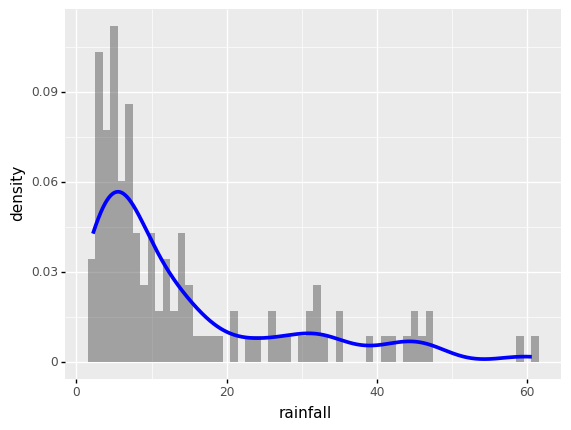

<ggplot: (343916912)>

In [7]:
p = ggplot(df.loc[df['rainfall'] > 2])
p = p + geom_histogram(aes(x = 'rainfall', y='..density..'), binwidth=1, alpha=0.5)
p + stat_density(aes(x = 'rainfall'), geom = "line", position = "identity", color = 'blue', size = 1.5)  

### Our best guess for fitting two normal distributions on the data

* Let us take the data in the range $[0.4, 2]$ to fit the first normal distribution and the data in the range $[2, 20]$ to fit the second normal distribution.
* This will produce two normal distributions which are too concentrated but this is the best we can do without much theory.

In [8]:
mu = [None, None]
sigma = [None, None]

mu[0] = df.loc[(0.4 <= df['rainfall']) & (df['rainfall'] <= 2), 'rainfall'].mean()
sigma[0] = df.loc[(0.4 <= df['rainfall']) & (df['rainfall'] <= 2), 'rainfall'].std()
print(mu[0], sigma[0])

mu[1] = df.loc[(2 <= df['rainfall']) & (df['rainfall'] <= 20), 'rainfall'].mean()
sigma[1] = df.loc[(2 <= df['rainfall']) & (df['rainfall'] <= 20), 'rainfall'].std()
print(mu[1], sigma[1])

distr =[norm(loc = mu[0], scale=sigma[0]), norm(loc = mu[1], scale=sigma[1])]

0.9307692307692309 0.4616842404265281
7.237362637362639 4.352257354309838


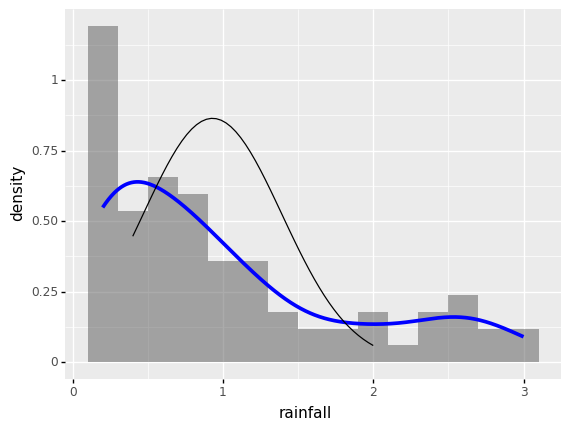

<ggplot: (381761777)>

In [9]:
pdf = DataFrame({'x': np.linspace(0.4, 2), 'y': distr[0].pdf(np.linspace(0.4, 2))})  

p = ggplot(df.loc[(df['rainfall'] >= 0.2) & (df['rainfall']<=3)] )
p = p + geom_histogram(aes(x = 'rainfall', y='..density..'), binwidth=0.2, alpha=0.5)
p = p + stat_density(aes(x = 'rainfall'), geom = "line", position = "identity", color = 'blue', size = 1.5) 
p + geom_line(aes(x = 'x', y = 'y'), data = pdf)

This estimation is clearly off, let us shift its mean $0.45$ units to the left and increase the width $30\%$. That seems to do the trick.

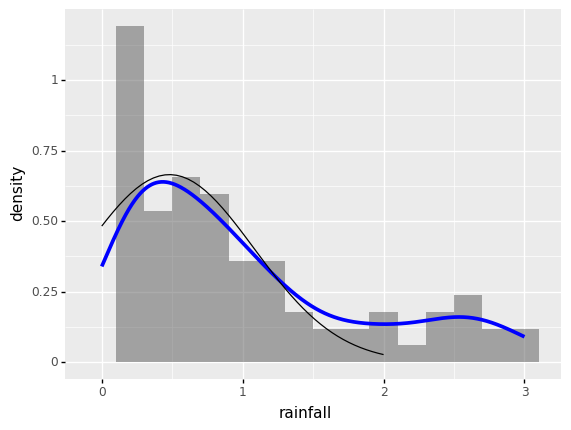

<ggplot: (343635755)>

In [10]:
pdf = (DataFrame({'x': np.linspace(0, 2)})
       .assign(y = lambda df: norm(loc=mu[0] - 0.45, scale = sigma[0] * 1.3).pdf(df['x'])))  

p = ggplot(df.loc[(df['rainfall'] >= 0.2) & (df['rainfall']<=3)] )
p = p + geom_histogram(aes(x = 'rainfall', y='..density..'), binwidth=0.2, alpha=0.5)
p = p + stat_density(aes(x = 'rainfall'), geom = "line", position = "identity", color = 'blue', size = 1.5) 
p + geom_line(aes(x = 'x', y = 'y'), data = pdf)

Similar fitting bias is visible for the second bump. 

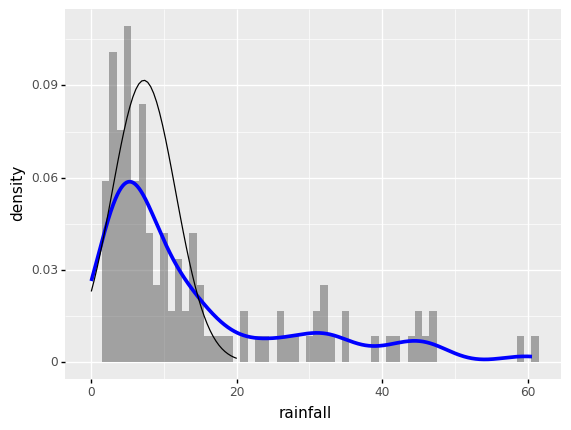

<ggplot: (343462087)>

In [11]:
pdf = DataFrame({'x': np.linspace(0, 20)}).assign(y = lambda df: distr[1].pdf(df['x']))  

p = ggplot(df.loc[df['rainfall'] >= 2])
p = p + geom_histogram(aes(x = 'rainfall', y='..density..'), binwidth=1, alpha=0.5)
p = p + stat_density(aes(x = 'rainfall'), geom = "line", position = "identity", color = 'blue', size = 1.5) 
p + geom_line(aes(x = 'x', y = 'y'), data = pdf)

Here the visual correction is $m=\mu-2$ and $\sigma=\sigma \cdot 1.7$. 

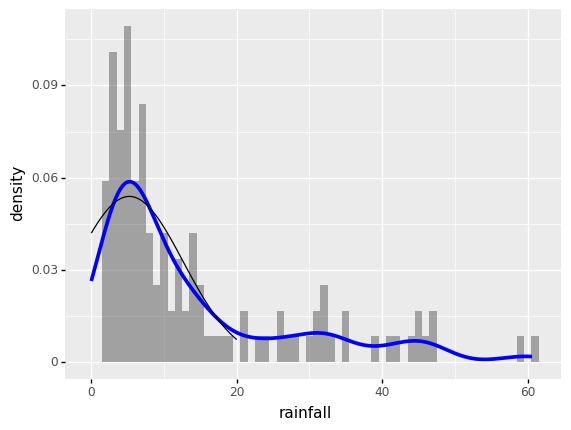

<ggplot: (343460115)>

In [12]:
pdf = (DataFrame({'x': np.linspace(0, 20)})
       .assign(y = lambda df: norm(loc=mu[1] - 2, scale = sigma[1] * 1.7).pdf(df['x'])))  

p = ggplot(df.loc[df['rainfall'] >= 2])
p = p + geom_histogram(aes(x = 'rainfall', y='..density..'), binwidth=1, alpha=0.5)
p = p + stat_density(aes(x = 'rainfall'), geom = "line", position = "identity", color = 'blue', size = 1.5) 
p + geom_line(aes(x = 'x', y = 'y'), data = pdf)

Thus we recalibrate our initial estimates for the ditribution.

In [13]:
distr =[norm(loc = mu[0] - 0.45, scale = sigma[0] * 1.3), norm(loc = mu[1]- 2, scale = sigma[1] * 1.7)]

## III. Computing marginal posterior probabilities with Hidden Markov Model

To fix the Hidden Markov Model we must fix the transition probabilities between states $0$ and $1$. For that we will use the following parametrised model.

<img src = 'illustrations/symmetric-two-state-model.png' width=100%>


### Computing local likelihoods

As we have fixed the likelihood model for both states, we can compute local likelihoods:

\begin{align*}
\lambda_{X_i}^*(x_i)=p[y_i|x_i]= p[y_i| y_i\sim\mathcal{N}(\mu_{x_i}, \sigma_{x_i})]\enspace.
\end{align*}

To keep our life simple we store the corresponding values into the columns `LL0` and `LL1`.

In [14]:
df = df.assign(LL0 = lambda df: distr[0].pdf(df['rainfall']), LL1 = lambda df: distr[1].pdf(df['rainfall']))
display(head(df))

,date,rainfall,temperature,wind_speed,quartile,LL0,LL1
0,2018-01-01,32.2,24.8,5.4,IV quantile,0.000000,0.000070
1,2018-01-02,0.8,25.5,7.9,III quantile,0.577020,0.045045
2,2018-01-03,2.0,26.6,7.2,III quantile,0.026997,0.048997
3,2018-01-04,0.2,26.1,8.3,II quantile,0.595802,0.042765
4,2018-01-05,1.0,26.0,4.3,III quantile,0.457199,0.045764


If we would not enforce correlations by modelling the states with the Markov chain we would get a labelling that switches quite quickly between dry and wet states.  

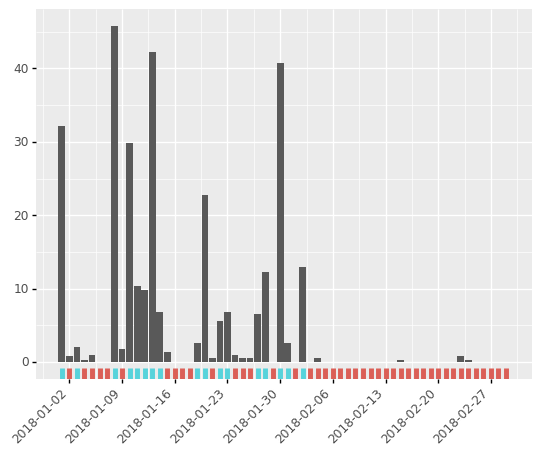

<ggplot: (381840604)>

In [15]:
p = ggplot(df.assign(state = lambda df: df['LL1'] >= df['LL0'])[0:60])
p = p + geom_col(aes(x = 'date', y = 'rainfall'))
p = p + geom_rug(aes(x = 'date', color = 'state'), size=2)
p = p + scale_x_date(name='', date_breaks = '1 week')
p = p + scale_y_continuous(name='')
p = p + scale_color_discrete(name="", guide=False)
p = p + theme(axis_text_x=element_text(rotation=45, hjust=1))
display(p)

### Prior propagation

<img src = 'illustrations/belief-propagation-in-hmm-ii.png' width=100%>

The general scheme for [propagating priors in a tree](belief-propagation_in_a_tree.ipynb) forces us to multiply $\pi_{X_i}\otimes\lambda_i^*$ before pushing it through the transformation matrix 

\begin{align*}
\begin{pmatrix}
\alpha & 1-\alpha\\
1-\alpha & \alpha
\end{pmatrix}\enspace.
\end{align*}

If we flatten the matrix formalisation into update formulae, we get

\begin{align*}
\pi_{X_i}(0) &=\alpha \cdot \pi_{X_{i-1}}(0)\cdot\lambda_{i-1}^*(0) + (1-\alpha)\cdot \pi_{X_{i-1}}(1)\cdot \lambda_{i-1}^*(1) \\
\pi_{X_i}(1) &=(1-\alpha)\cdot \pi_{X_{i-1}}(0)\cdot \lambda_{i-1}^*(0) + \alpha\cdot \pi_{X_{i-1}}(1)\cdot \lambda_{i-1}^*(1)\enspace.
\end{align*}

We also need a starting condition for the prior. Since we have no preferences for the starting states, we use

\begin{align*}
\pi_{X_0}(0) &=\frac{1}{2} \\
\pi_{X_0}(1) &=\frac{1}{2}\enspace.
\end{align*}

To keep our life simple, we store the prior values as columns `P0` and `P1`. For the smoothing we use $\alpha=0.95$.

As we need priors up to a multiplicative constant, we normalise them. This keeps the values in a reasonable range so that floating point errors do not corrupt our results. 

In [16]:
alpha = 0.95 

df = df.assign(P0 = np.nan, P1 = np.nan)
df.loc[0, 'P0'] = 0.5
df.loc[0, 'P1'] = 0.5

for i in range(1, len(df)):
    pi_0 = alpha * df.loc[i - 1, 'P0'] * df.loc[i - 1, 'LL0'] + (1 - alpha) * df.loc[i - 1, 'P1'] * df.loc[i - 1, 'LL1']
    pi_1 = alpha * df.loc[i - 1, 'P1'] * df.loc[i - 1, 'LL1'] + (1 - alpha) * df.loc[i - 1, 'P0'] * df.loc[i - 1, 'LL0']
    df.loc[i, 'P0'] = pi_0/(pi_0 + pi_1)
    df.loc[i, 'P1'] = pi_1/(pi_0 + pi_1)

mdisplay([head(df[['rainfall', 'LL0', 'LL1', 'P0', 'P1']]), tail(df[['rainfall', 'LL0', 'LL1', 'P0', 'P1']])])


rainfall,LL0,LL1,P0,P1
32.2,0.000000,0.000070,0.500000,0.500000
0.8,0.577020,0.045045,0.050000,0.950000
2.0,0.026997,0.048997,0.412433,0.587567
0.2,0.595802,0.042765,0.301001,0.698999
1.0,0.457199,0.045764,0.821416,0.178584
rainfall,LL0,LL1,P0,P1
0.0,4.822694e-01,0.041970,0.946308,0.053692
0.0,4.822694e-01,0.041970,0.945578,0.054422
0.0,4.822694e-01,0.041970,0.945515,0.054485
17.4,1.833054e-173,0.013962,0.945509,0.054491


Note that the prior tracks what the state should be according to the previous state and the smoothness constraint forced by the Markov model.

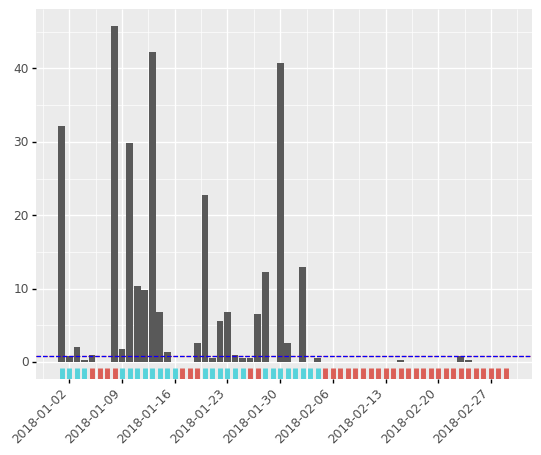

<ggplot: (381954597)>

In [17]:
p = ggplot(df.assign(state = lambda df: df['P1'] >= df['P0'])[0:60])
p = p + geom_col(aes(x = 'date', y = 'rainfall'))
p = p + geom_hline(yintercept = distr[0].kwds['loc'] + 0.6*distr[0].kwds['scale'], linetype='--', color='red')
p = p + geom_hline(yintercept = distr[1].kwds['loc'] - 0.6*distr[1].kwds['scale'], linetype='--', color='blue')
p = p + geom_rug(aes(x = 'date', color = 'state'), size=2)
p = p + scale_x_date(name='', date_breaks = '1 week')
p = p + scale_y_continuous(name='')
p = p + scale_color_discrete(name="", guide=False)
p = p + theme(axis_text_x=element_text(rotation=45, hjust=1))
display(p)

### Filtering

If we multiply the prior with local likelihood, the resulting posterior looks only at the values $y_1,\ldots, y_i$ to make the decision about the state $x_i$ and thus whatever occurs in the future does not affect the state.
To store these marginal posteriors $\Pr[x_i|y_1,\ldots, y_i]$, we use columns `F1` and `F2`.

In [18]:
df = (df
      .assign(F0 = lambda df: df['LL0'] * df['P0'] / (df['LL0'] * df['P0'] + df['LL1'] * df['P1']))
      .assign(F1 = lambda df: df['LL1'] * df['P1'] / (df['LL0'] * df['P0'] + df['LL1'] * df['P1'])))

mdisplay([head(df[['rainfall', 'LL0', 'LL1', 'P0', 'P1', 'F0', 'F1']]), 
          tail(df[['rainfall', 'LL0', 'LL1', 'P0', 'P1', 'F0', 'F1']])])

rainfall,LL0,LL1,P0,P1,F0,F1
32.2,0.000000,0.000070,0.500000,0.500000,0.000000,1.000000
0.8,0.577020,0.045045,0.050000,0.950000,0.402703,0.597297
2.0,0.026997,0.048997,0.412433,0.587567,0.278890,0.721110
0.2,0.595802,0.042765,0.301001,0.698999,0.857129,0.142871
1.0,0.457199,0.045764,0.821416,0.178584,0.978701,0.021299
rainfall,LL0,LL1,P0,P1,F0,F1
0.0,4.822694e-01,0.041970,0.946308,0.053692,9.950866e-01,0.004913
0.0,4.822694e-01,0.041970,0.945578,0.054422,9.950162e-01,0.004984
0.0,4.822694e-01,0.041970,0.945515,0.054485,9.950101e-01,0.004990
17.4,1.833054e-173,0.013962,0.945509,0.054491,2.278037e-170,1.000000


This helps to correct the labelling for several cases, but we still label days before heavy rains as part of a dry season.

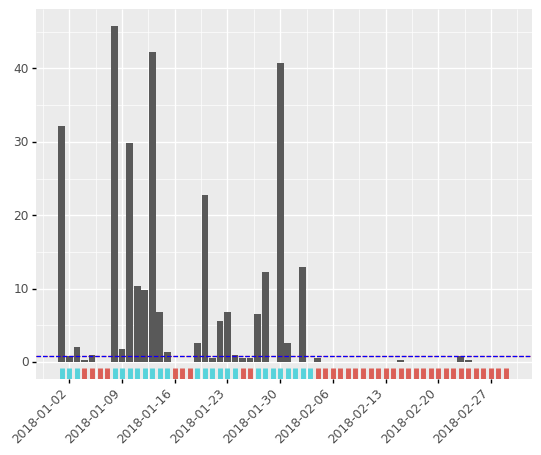

<ggplot: (381954660)>

In [19]:
p = ggplot(df.assign(state = lambda df: df['F1'] >= df['F0'])[0:60])
p = p + geom_col(aes(x = 'date', y = 'rainfall'))
p = p + geom_hline(yintercept = distr[0].kwds['loc'] + 0.6 * distr[0].kwds['scale'], linetype='--', color='red')
p = p + geom_hline(yintercept = distr[1].kwds['loc'] - 0.6 * distr[1].kwds['scale'], linetype='--', color='blue')
p = p + geom_rug(aes(x = 'date', color = 'state'), size=2)
p = p + scale_x_date(name='', date_breaks = '1 week')
p = p + scale_y_continuous(name='')
p = p + scale_color_discrete(name="", guide=False)
p = p + theme(axis_text_x=element_text(rotation=45, hjust=1))
display(p)

### Likelihood propagation


<img src = 'illustrations/belief-propagation-in-hmm-iii.png' width=100%>

The general scheme for [propagating likelihoods in a tree](belief-propagation_in_a_tree.ipynb) forces us to push $\lambda_{X_{i+1}}$ through the state transformation matrix and then multiply with the local likelihood $\lambda_{i}^*$ which represents the influence coming from the second child of $X_i$.

If we flatten the matrix formalisation into update formulae, we get

\begin{align*}
\lambda_{X_i}(0) &=\lambda_i^*(0)\cdot(\alpha \cdot  \lambda_{X_{i+1}}(0) + (1-\alpha)\cdot \lambda_{X_{i+1}}(1))  \\
\lambda_{X_i}(1) &=\lambda_i^*(0)\cdot((1-\alpha)\cdot \lambda_{X_{i+1}}(0) + \alpha\cdot \lambda_{X_{i+1}}(1))\enspace.
\end{align*}

We also need an ending condition for the likelihoods. This is obviously the local likelihood

\begin{align*}
\lambda_{X_n}(0) &=\lambda_n^*(0) \\
\lambda_{X_n}(1) &=\lambda_n^*(1)\enspace.
\end{align*}

To keep our life simple, we store these likelihood values as columns `L0` and `L1`. 

As we need likelihoods up to a multiplicative constant, we normalise them. This keeps the values in a reasonable range so that floating point errors do not corrupt our results. 

In [20]:
df = df.assign(L0 = np.nan , L1 = np.nan)

df.loc[len(df) - 1, 'L0'] = df.loc[len(df) - 1, 'LL0'] / (df.loc[len(df) - 1, 'LL0'] + df.loc[len(df) - 1, 'LL1'])
df.loc[len(df) - 1, 'L1'] = df.loc[len(df) - 1, 'LL1'] / (df.loc[len(df) - 1, 'LL0'] + df.loc[len(df) - 1, 'LL1'])


for i in reversed(range(len(df)-1)):
    l0 = (alpha * df.loc[i + 1, 'L0'] + (1 - alpha) * df.loc[i + 1, 'L1']) * df.loc[i, 'LL0'] 
    l1 = (alpha * df.loc[i + 1, 'L1'] + (1 - alpha) * df.loc[i + 1, 'L0']) * df.loc[i, 'LL1'] 
    df.loc[i, 'L0'] = l0/(l0 + l1)
    df.loc[i, 'L1'] = l1/(l0 + l1)

display(head(df[['rainfall', 'LL0', 'LL1', 'P0', 'P1', 'F0', 'F1', 'L0', 'L1']])) 
display(tail(df[['rainfall', 'LL0', 'LL1', 'P0', 'P1', 'F0', 'F1', 'L0', 'L1']]))

,rainfall,LL0,LL1,P0,P1,F0,F1,L0,L1
0,32.2,0.000000,0.000070,0.500000,0.500000,0.000000,1.000000,0.000000,1.000000
1,0.8,0.577020,0.045045,0.050000,0.950000,0.402703,0.597297,0.987926,0.012074
2,2.0,0.026997,0.048997,0.412433,0.587567,0.278890,0.721110,0.905147,0.094853
3,0.2,0.595802,0.042765,0.301001,0.698999,0.857129,0.142871,0.994904,0.005096
4,1.0,0.457199,0.045764,0.821416,0.178584,0.978701,0.021299,0.981542,0.018458


,rainfall,LL0,LL1,P0,P1,F0,F1,L0,L1
360,0.0,4.822694e-01,0.041970,0.946308,0.053692,9.950866e-01,0.004913,9.839132e-01,0.016087
361,0.0,4.822694e-01,0.041970,0.945578,0.054422,9.950162e-01,0.004984,8.798236e-01,0.120176
362,0.0,4.822694e-01,0.041970,0.945515,0.054485,9.950101e-01,0.004990,3.768606e-01,0.623139
363,17.4,1.833054e-173,0.013962,0.945509,0.054491,2.278037e-170,1.000000,6.909798e-173,1.000000
364,39.2,0.000000e+00,0.000001,0.050000,0.950000,0.000000e+00,1.000000,0.000000e+00,1.000000


As one could guess, the likelihood $\Pr[y_i,\ldots,y_n|x_i]$ labels days according to the events occuring in the future and the same day, and propagates heavy wet seasons into previous days.

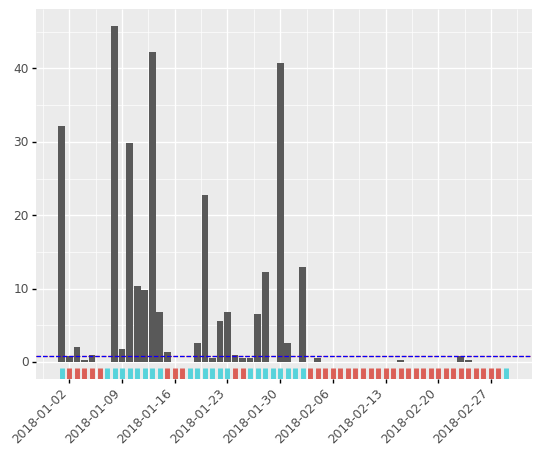

<ggplot: (381907987)>

In [21]:
p = ggplot(df.assign(state = lambda df: df['L1'] >= df['L0'])[0:60])
p = p + geom_col(aes(x = 'date', y = 'rainfall'))
p = p + geom_hline(yintercept = distr[0].kwds['loc'] + 0.6 * distr[0].kwds['scale'], linetype='--', color='red')
p = p + geom_hline(yintercept = distr[1].kwds['loc'] - 0.6 * distr[1].kwds['scale'], linetype='--', color='blue')
p = p + geom_rug(aes(x = 'date', color = 'state'), size=2)
p = p + scale_x_date(name='', date_breaks = '1 week')
p = p + scale_y_continuous(name='')
p = p + scale_color_discrete(name="", guide=False)
p = p + theme(axis_text_x=element_text(rotation=45, hjust=1))
display(p)

### Smoothing 

Finally we can compute the marginal posterior probabilities $\Pr[x_i|y_1,\ldots, y_n]$  for each day by multiplying the priors and likelihoods. This is known as smoothing. We store the corresponding values in columns `S0` and `S1`.

In [22]:
df = (df
      .assign(S0 = lambda df: df['P0'] * df['L0'] / (df['P0'] * df['L0'] + df['P1'] * df['L1']))
      .assign(S1 = lambda df: df['P1'] * df['L1'] / (df['P0'] * df['L0'] + df['P1'] * df['L1']))
     )

display(head(df[['rainfall', 'LL0', 'LL1', 'P0', 'P1', 'F0', 'F1', 'L0', 'L1', 'S0', 'S1']])) 
display(tail(df[['rainfall', 'LL0', 'LL1', 'P0', 'P1', 'F0', 'F1', 'L0', 'L1', 'S0', 'S1']]))

,rainfall,LL0,LL1,P0,P1,F0,F1,L0,L1,S0,S1
0,32.2,0.000000,0.000070,0.500000,0.500000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.8,0.577020,0.045045,0.050000,0.950000,0.402703,0.597297,0.987926,0.012074,0.811548,0.188452
2,2.0,0.026997,0.048997,0.412433,0.587567,0.278890,0.721110,0.905147,0.094853,0.870101,0.129899
3,0.2,0.595802,0.042765,0.301001,0.698999,0.857129,0.142871,0.994904,0.005096,0.988244,0.011756
4,1.0,0.457199,0.045764,0.821416,0.178584,0.978701,0.021299,0.981542,0.018458,0.995928,0.004072


,rainfall,LL0,LL1,P0,P1,F0,F1,L0,L1,S0,S1
360,0.0,4.822694e-01,0.041970,0.946308,0.053692,9.950866e-01,0.004913,9.839132e-01,0.016087,9.990732e-01,0.000927
361,0.0,4.822694e-01,0.041970,0.945578,0.054422,9.950162e-01,0.004984,8.798236e-01,0.120176,9.921999e-01,0.007800
362,0.0,4.822694e-01,0.041970,0.945515,0.054485,9.950101e-01,0.004990,3.768606e-01,0.623139,9.130058e-01,0.086994
363,17.4,1.833054e-173,0.013962,0.945509,0.054491,2.278037e-170,1.000000,6.909798e-173,1.000000,1.198967e-171,1.000000
364,39.2,0.000000e+00,0.000001,0.050000,0.950000,0.000000e+00,1.000000,0.000000e+00,1.000000,0.000000e+00,1.000000


The final smoothing keeps the balance between the future and the past.

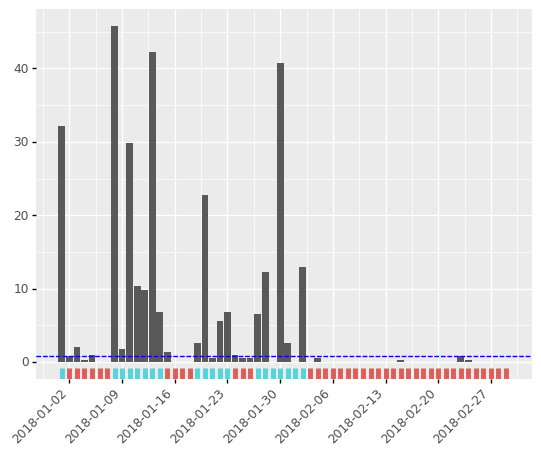

<ggplot: (381785471)>

In [23]:
p = ggplot(df.assign(state = lambda df: df['S1'] >= df['S0'])[0:60])
p = p + geom_col(aes(x = 'date', y = 'rainfall'))
p = p + geom_hline(yintercept = distr[0].kwds['loc'] + 0.6 * distr[0].kwds['scale'], linetype='--', color='red')
p = p + geom_hline(yintercept = distr[1].kwds['loc'] - 0.6 * distr[1].kwds['scale'], linetype='--', color='blue')
p = p + geom_rug(aes(x = 'date', color = 'state'), size=2)
p = p + scale_x_date(name='', date_breaks = '1 week')
p = p + scale_y_continuous(name='')
p = p + scale_color_discrete(name="", guide=False)
p = p + theme(axis_text_x=element_text(rotation=45, hjust=1))
display(p)

The following figure shows how the labelling changes if we consider:
* local likelihood
* filtering 
* likelihood (reverse filtering)
* smoothing

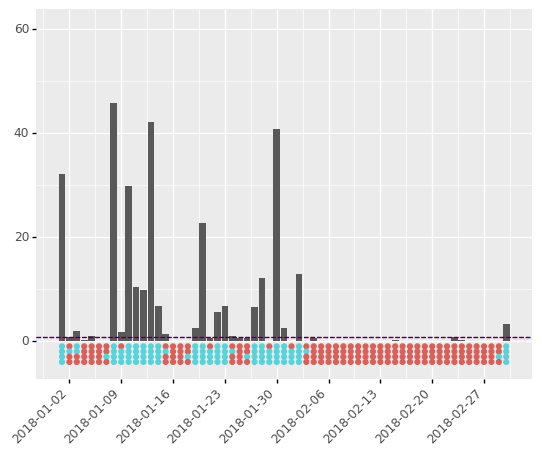

<ggplot: (343828947)>

In [24]:
tmp = (df
       .assign(llstate = lambda df: df['LL0'] <= df['LL1'])
       .assign(fstate = lambda df: df['F0'] <= df['F1'])
       .assign(lstate = lambda df: df['L0'] <= df['L1'])
       .assign(sstate = lambda df: df['S0'] <= df['S1']))


p = ggplot(tmp.loc[0:60])
p = p + geom_col(aes(x = 'date', y = 'rainfall'))
p = p + geom_hline(yintercept = distr[0].kwds['loc'] + 0.6 * distr[0].kwds['scale'], linetype='--', color='red')
p = p + geom_hline(yintercept = distr[1].kwds['loc'] - 0.6 * distr[1].kwds['scale'], linetype='--', color='blue')
p = p + geom_point(aes(x = 'date', color = 'llstate'), y=-1) 
p = p + geom_point(aes(x = 'date', color = 'fstate'),  y=-2)
p = p + geom_point(aes(x = 'date', color = 'lstate'),  y=-3)
p = p + geom_point(aes(x = 'date', color = 'sstate'),  y=-4) 
p = p + scale_x_date(name='', date_breaks = '1 week')
p = p + scale_y_continuous(name='', limits = (-4, df['rainfall'].max()))
p = p + scale_color_discrete(name="", guide=False)
p = p + theme(axis_text_x=element_text(rotation=45, hjust=1))
display(p)

As you can see, smoothing extends dry weather regions maximally. 
* This is because the emission probabilities $p[y_i|x_i]$ are way off and days with low rainfall get extremely low local likelihoods for the wet state. 
* A more detailed visualisation of distribution densities shows that no day with rainfall over $2$ mm is declared as part of a dry period, as the tail of the normal distribution quickly falls off.

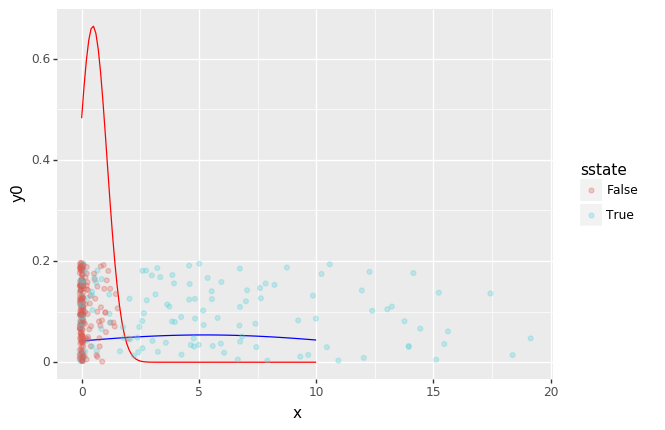

<ggplot: (-9223363272035341582)>

In [25]:
pdf = (DataFrame({'x': np.linspace(0, 10, 100)})
       .assign(y0 = lambda df: distr[0].pdf(df['x']))
       .assign(y1 = lambda df: distr[1].pdf(df['x']))
      )

tmp = (df
       .assign(llstate = lambda df: df['LL0'] <= df['LL1'])
       .assign(fstate = lambda df: df['F0'] <= df['F1'])
       .assign(lstate = lambda df: df['L0'] <= df['L1'])
       .assign(sstate = lambda df: df['S0'] <= df['S1']))

p = ggplot(pdf)
p = p + geom_line(aes(x = 'x', y = 'y0'), color = 'red')
p = p + geom_line(aes(x = 'x', y = 'y1'), color = 'blue')
p = p + geom_jitter(aes(x = 'rainfall',  y=0.1, color = 'sstate'), height=0.1, alpha=0.3, data=tmp[tmp['rainfall'] <= 20])
p

# Homework

## 5.1 Cascading three-state model for rainfall (<font color='red'>2p</font>)

The histogram clearly indicates the emission distributions cannot be reliably approximated with a normal distribution. This can be resolved by introducing three states: dry, normal, wet. You can model the likelihood distribution of the dry state by choosing a uniform distribution for the region $[0, 0.5]$ and fitting the other data with normal distributions as before. If you want to achieve smoother results you should also inflate the standard deviation component for the first normal distribution but the amount of model tuning is left for your discretion.  

For smoother results, use the symmetric cascading three-state transition diagram which forces all changes to go through the intermediate state. 
As before, you can take the parameter $\alpha=0.95$.

<img src = 'illustrations/cascading-three-state-model.png' width=100%>

* Implement the computation of local likelihoods and show the annotations without any filtering or smoothing. (<font color='red'>**1p**</font>)

* Implement the belief propagation and show the annnotations based on filtering, reverse filtering and smoothing. Interpret the results.
  Did we achieve what we wanted – more continuous regions of weather patterns? (<font color='red'>**1p**</font>)  

**Extra task:** What happens if we force the state to go from dry to wet without the ability to occilate between dry and normal, and between normal and wet? That is, consider the following four state transition diagram. Compare the labelling from this model with the labelling of the three-state model and explain what happens. (<font color='red'>**1p**</font>)

<img src = 'illustrations/four-state-model.png' width=100%>

## 5.2 Using other observations to label the weather data* (<font color='red'>2p</font>)

The weather data contains other variables like windspeed and temperature. These are reasonably uncorrelated so that you could model each of these as independent normal distributions. As a result, the HMM model is replaced with another tree-like structure where $X_i$ has three descendant nodes $Y_i$, $Z_i$ and $X_{i+1}$. Using belief propagation methods, derive the formulae for filtering and smoothing and perform the analysis we did above. What changes? 

In [26]:
# Import data
df=[None] * 12
for i in range(1,13):
    df[i-1] = pd.read_csv('data/weather-data/DAILYDATA_S24_2018{:02d}.csv'.format(i), encoding='latin1')
df = pd.concat(df, ignore_index=True)
display(head(df))

,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h)
0,Changi,2018,1,1,32.2,6.0,11.6,13.4,24.8,26.7,23.6,5.4,36.0
1,Changi,2018,1,2,0.8,0.4,0.4,0.4,25.5,27.3,24.3,7.9,24.5
2,Changi,2018,1,3,2.0,1.8,2.0,2.0,26.6,31.1,24.1,7.2,29.2
3,Changi,2018,1,4,0.2,0.2,0.2,0.2,26.1,28.2,25.0,8.3,23.8
4,Changi,2018,1,5,1.0,1.0,1.0,1.0,26.0,29.0,24.8,4.3,18.7


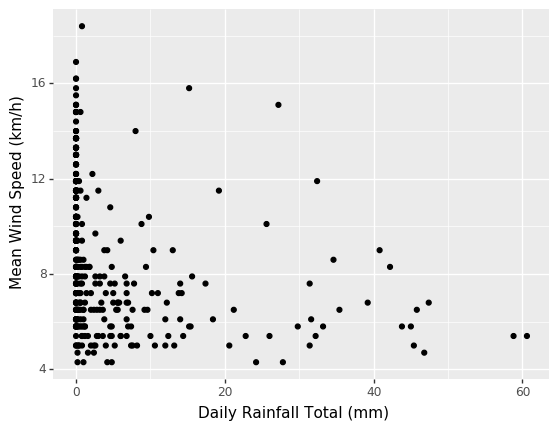

<ggplot: (7018394295)>

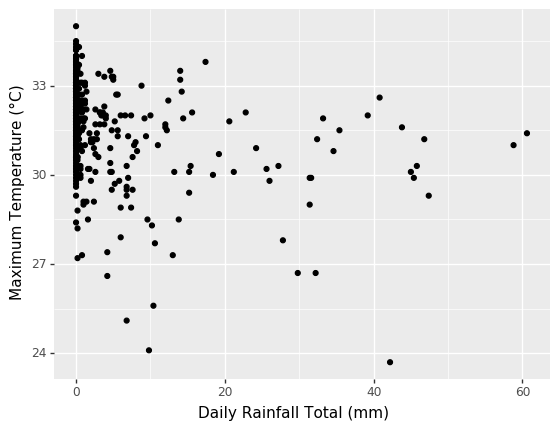

<ggplot: (7018143422)>

In [27]:
p = ggplot(df)
display(p + geom_point(aes(x='Daily Rainfall Total (mm)', y='Mean Wind Speed (km/h)')))
display(p + geom_point(aes(x='Daily Rainfall Total (mm)', y='Maximum Temperature (°C)')))

## 5.3 Analysis of hosehold power consumption (<font color='red'>1p</font>)

Our example analysis was not good as the data did not clearly follow the model – emission probabilities were way off from true normal distributions. Let us consider the 
[UCI Individual household electric power consumption data set](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption) instead. This data is with clear power consumption states. In particular, let us analyse the data of the first sub-metering, which according to the data description corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). 

* Define a symmetric three-state transition model and fix the parameters of normal distributions defined for each state.  

<img src = 'illustrations/symmetric-three-state-model.png' width=100%>

* Implement computations of local likelihoods. The data contains missing values so for these nodes the local likelihoods $\lambda_i\propto \boldsymbol{1}$. There are no more new artefacts to consider.

* Implement belief propagation and show the annotations based on filtering, reverse filtering and smoothing. 

* Interpret results. What are the most common consumption patterns in the kitchen? Do they make sense?   

In [28]:
df=pd.read_csv('data/household-power-consumption/household_power_consumption.csv', sep=";", na_values='?')
head(df)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


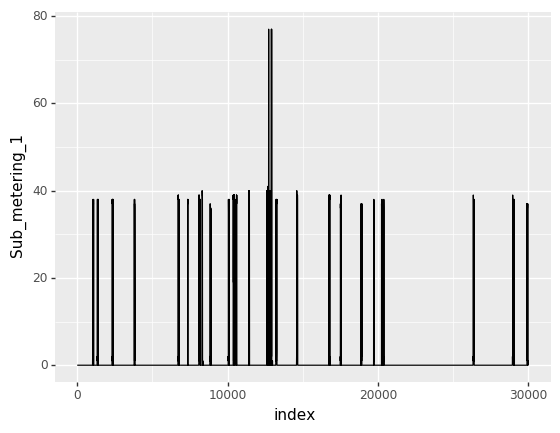

<ggplot: (-9223372029836221948)>

In [29]:
p = ggplot(df.loc[0:30000].reset_index())
p + geom_line(aes(x = 'index', y='Sub_metering_1'))